# Подготовка и анализ опорной выборки

1. Исходная опорная выборка содержит классы, размеченные согласно [легенде из 33-х классов земного покрова](../data/raw/33class_legend_rus.txt). В данной легенде единственному классу могут соответствовать несколько индексов. Чтобы избежать неудобств в дальнейшей работе, связанных с этим фактом, необходимо разметить классы опорной выборки согласно [легенде из 23-х классов земного покрова](../data/raw/23class_legend_rus.txt), где каждому классу соответствует единственный индекс. Соответствие индексов легенды 33-х классов индексам легенды 23-х классов описано в [файле](../data/raw/33class-23class.txt).

2. Опорную выборку желательно обрезать, оставив только пиксели, содержащие данные, во избежание затрат времени на чтение и запись неинформативных пикселей в дальнейшей работе.

3. Необходимо сохранить опорную выборку со стандартной легендой цветов (которую можно получить из [карты земного покрова](../data/raw/MODIS-2020/2020_map_33class.img)), заменив цвет фона на прозрачный.

4. Получить информацию о распределении классов в опорной выборке.

5. Выяснить, какие классы имеют смысл для пространственного разрешения 10 м.

## Imports & configs

In [1]:
# Imports

import rasterio as rio
from rasterio.plot import show, show_hist
from rasterio.windows import Window
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

# Importing and reloading custom modules

import os, sys
from importlib import reload

BASE_DIR = os.path.dirname(os.getcwd())
if BASE_DIR not in sys.path:
    sys.path.append(BASE_DIR)

from src import config, utils

custom_modules = [
    module
    for module_name, module in sys.modules.items()
    if module_name.startswith("src.")
]

for custom_module in custom_modules:
    reload(custom_module)

In [3]:
# Config

experiment_name = "MODIS-2020-sample-preparation-and-analysis"
interim_dir, processed_dir = utils.make_experiment_dirs(experiment_name, models=False)

sample_raw_path = os.path.join(config.RAW_DATA_DIR, "MODIS-2020/lccswm2020_11.img")
map_raw_path = os.path.join(config.RAW_DATA_DIR, "MODIS-2020/2020_map_33class.img")
classes_33_to_23_legend_raw_path = os.path.join(
    config.RAW_DATA_DIR, "33class-23class.txt"
)
classes_23_legend_raw_path = os.path.join(config.RAW_DATA_DIR, "23class_legend_rus.txt")

sample_classes_23_path = os.path.join(interim_dir, "MODIS_2020_sample_classes_23.tif")
sample_classes_23_cropped_path = os.path.join(
    interim_dir, "MODIS_2020_sample_classes_23_cropped.tif"
)

cmap_path = os.path.join(processed_dir, "colormap.json")
sample_classes_23_cropped_colored_path = os.path.join(
    processed_dir, "MODIS_2020_sample.tif"
)

stats_path = os.path.join(processed_dir, "MODIS_2020_sample_stats.csv")
plot_path = os.path.join(processed_dir, "MODIS_2020_sample_stats.png")

## 1. Замена меток классов в выборке

In [16]:
%%time

classes_33_to_23_dict = utils.get_classes_33_to_23_dict(
    classes_33_to_23_legend_raw_path
)

with rio.open(sample_raw_path) as src_img:
    sample_classes_33 = src_img.read(1)
    sample_classes_23 = utils.replace_2d_ndarray_values(
        sample_classes_33, classes_33_to_23_dict
    )
    profile = src_img.profile
    profile["driver"] = "GTiff"
    with rio.open(sample_classes_23_path, "w", **profile) as dst_img:
        dst_img.write(sample_classes_23, 1)

CPU times: total: 23min 35s
Wall time: 23min 35s


## 2. Обрезка выборки

In [162]:
with rio.open(sample_classes_23_path) as src_img:
    sample_classes_23 = src_img.read(1)

    nonzero_rows, nonzero_cols = np.nonzero(sample_classes_23)
    top = np.min(nonzero_rows)
    bottom = np.max(nonzero_rows)
    left = np.min(nonzero_cols)
    right = np.max(nonzero_cols)

    xsize, ysize = right - left + 1, bottom - top + 1
    xoff, yoff = left, top

    window = Window(xoff, yoff, xsize, ysize)
    transform = src_img.window_transform(window)

    profile = src_img.profile
    profile.update({"height": ysize, "width": xsize, "transform": transform})

    with rio.open(sample_classes_23_cropped_path, "w", **profile) as dst_img:
        sample_cropped = src_img.read(1, window=window)
        dst_img.write(sample_cropped, 1)

## 3. Сохранение выборки со стандартной легендой цветов

In [ ]:
with rio.open(map_raw_path) as src_map_img:
    cmap = src_map_img.colormap(1)
    cmap[0] = (0, 0, 0, 0)
    with open(cmap_path, "w") as cmap_json:
        json.dump(
            cmap, cmap_json
        )  # TODO: JSON поддерживает только строковые ключи, поэтому при сохранении словаря в JSON-файл целочисленные ключи преобразуются в строки. При считывании карты цветов из JSON-файла с целью дальнейшего использования необходимо будет преобразовать строковые ключи обратно к целочисленным.

    with rio.open(sample_classes_23_cropped_path) as src_sample_img:
        sample = src_sample_img.read(1)
        profile = src_sample_img.profile
        profile.update({"nodata": 0})

        with rio.open(
            sample_classes_23_cropped_colored_path, "w", **profile
        ) as dst_img:
            dst_img.write(sample, 1)
            dst_img.write_colormap(1, cmap)

## 4. Распределение классов в выборке

In [6]:
with rio.open(sample_classes_23_cropped_colored_path) as src_img:
    sample = src_img.read(1)

In [7]:
nonzero_rows, nonzero_cols = np.nonzero(sample)
nonzero_sample = sample[nonzero_rows, nonzero_cols]
classes, counts = np.unique(nonzero_sample, return_counts=True)
n_points = np.sum(counts)
n_classes = len(classes)
classes_23_dict = utils.get_classes_23_dict(classes_23_legend_raw_path)

In [74]:
stats = pd.DataFrame(
    {
        "class": classes,
        "name": [classes_23_dict[i] for i in classes],
        "count": counts,
        "percent": [i / n_points * 100 for i in counts],
    }
)
stats.to_csv(stats_path)

In [78]:
print(f"В выборке {n_classes} классов, {n_points} точек")

В выборке 18 классов, 66369468 точек


In [8]:
stats = pd.read_csv(stats_path, index_col=0)
stats

,class,name,count,percent
0,1,Темнохвойный лес,5672642,8.547066
1,2,Светлохвойный лес,4262879,6.422952
2,3,Лиственный лес,6697019,10.090512
3,4,Смешанный лес с преобладанием хвойных,208217,0.313724
4,5,Смешанный лес,308406,0.464681
5,6,Смешанный лес с преобладанием лиственных,1383131,2.083987
6,7,Хвойный листопадный лес,20418633,30.765100
7,8,Редины хвойные листопадные,3327996,5.014348
8,9,Луга,5772610,8.697689
9,10,Степь,2081306,3.135939


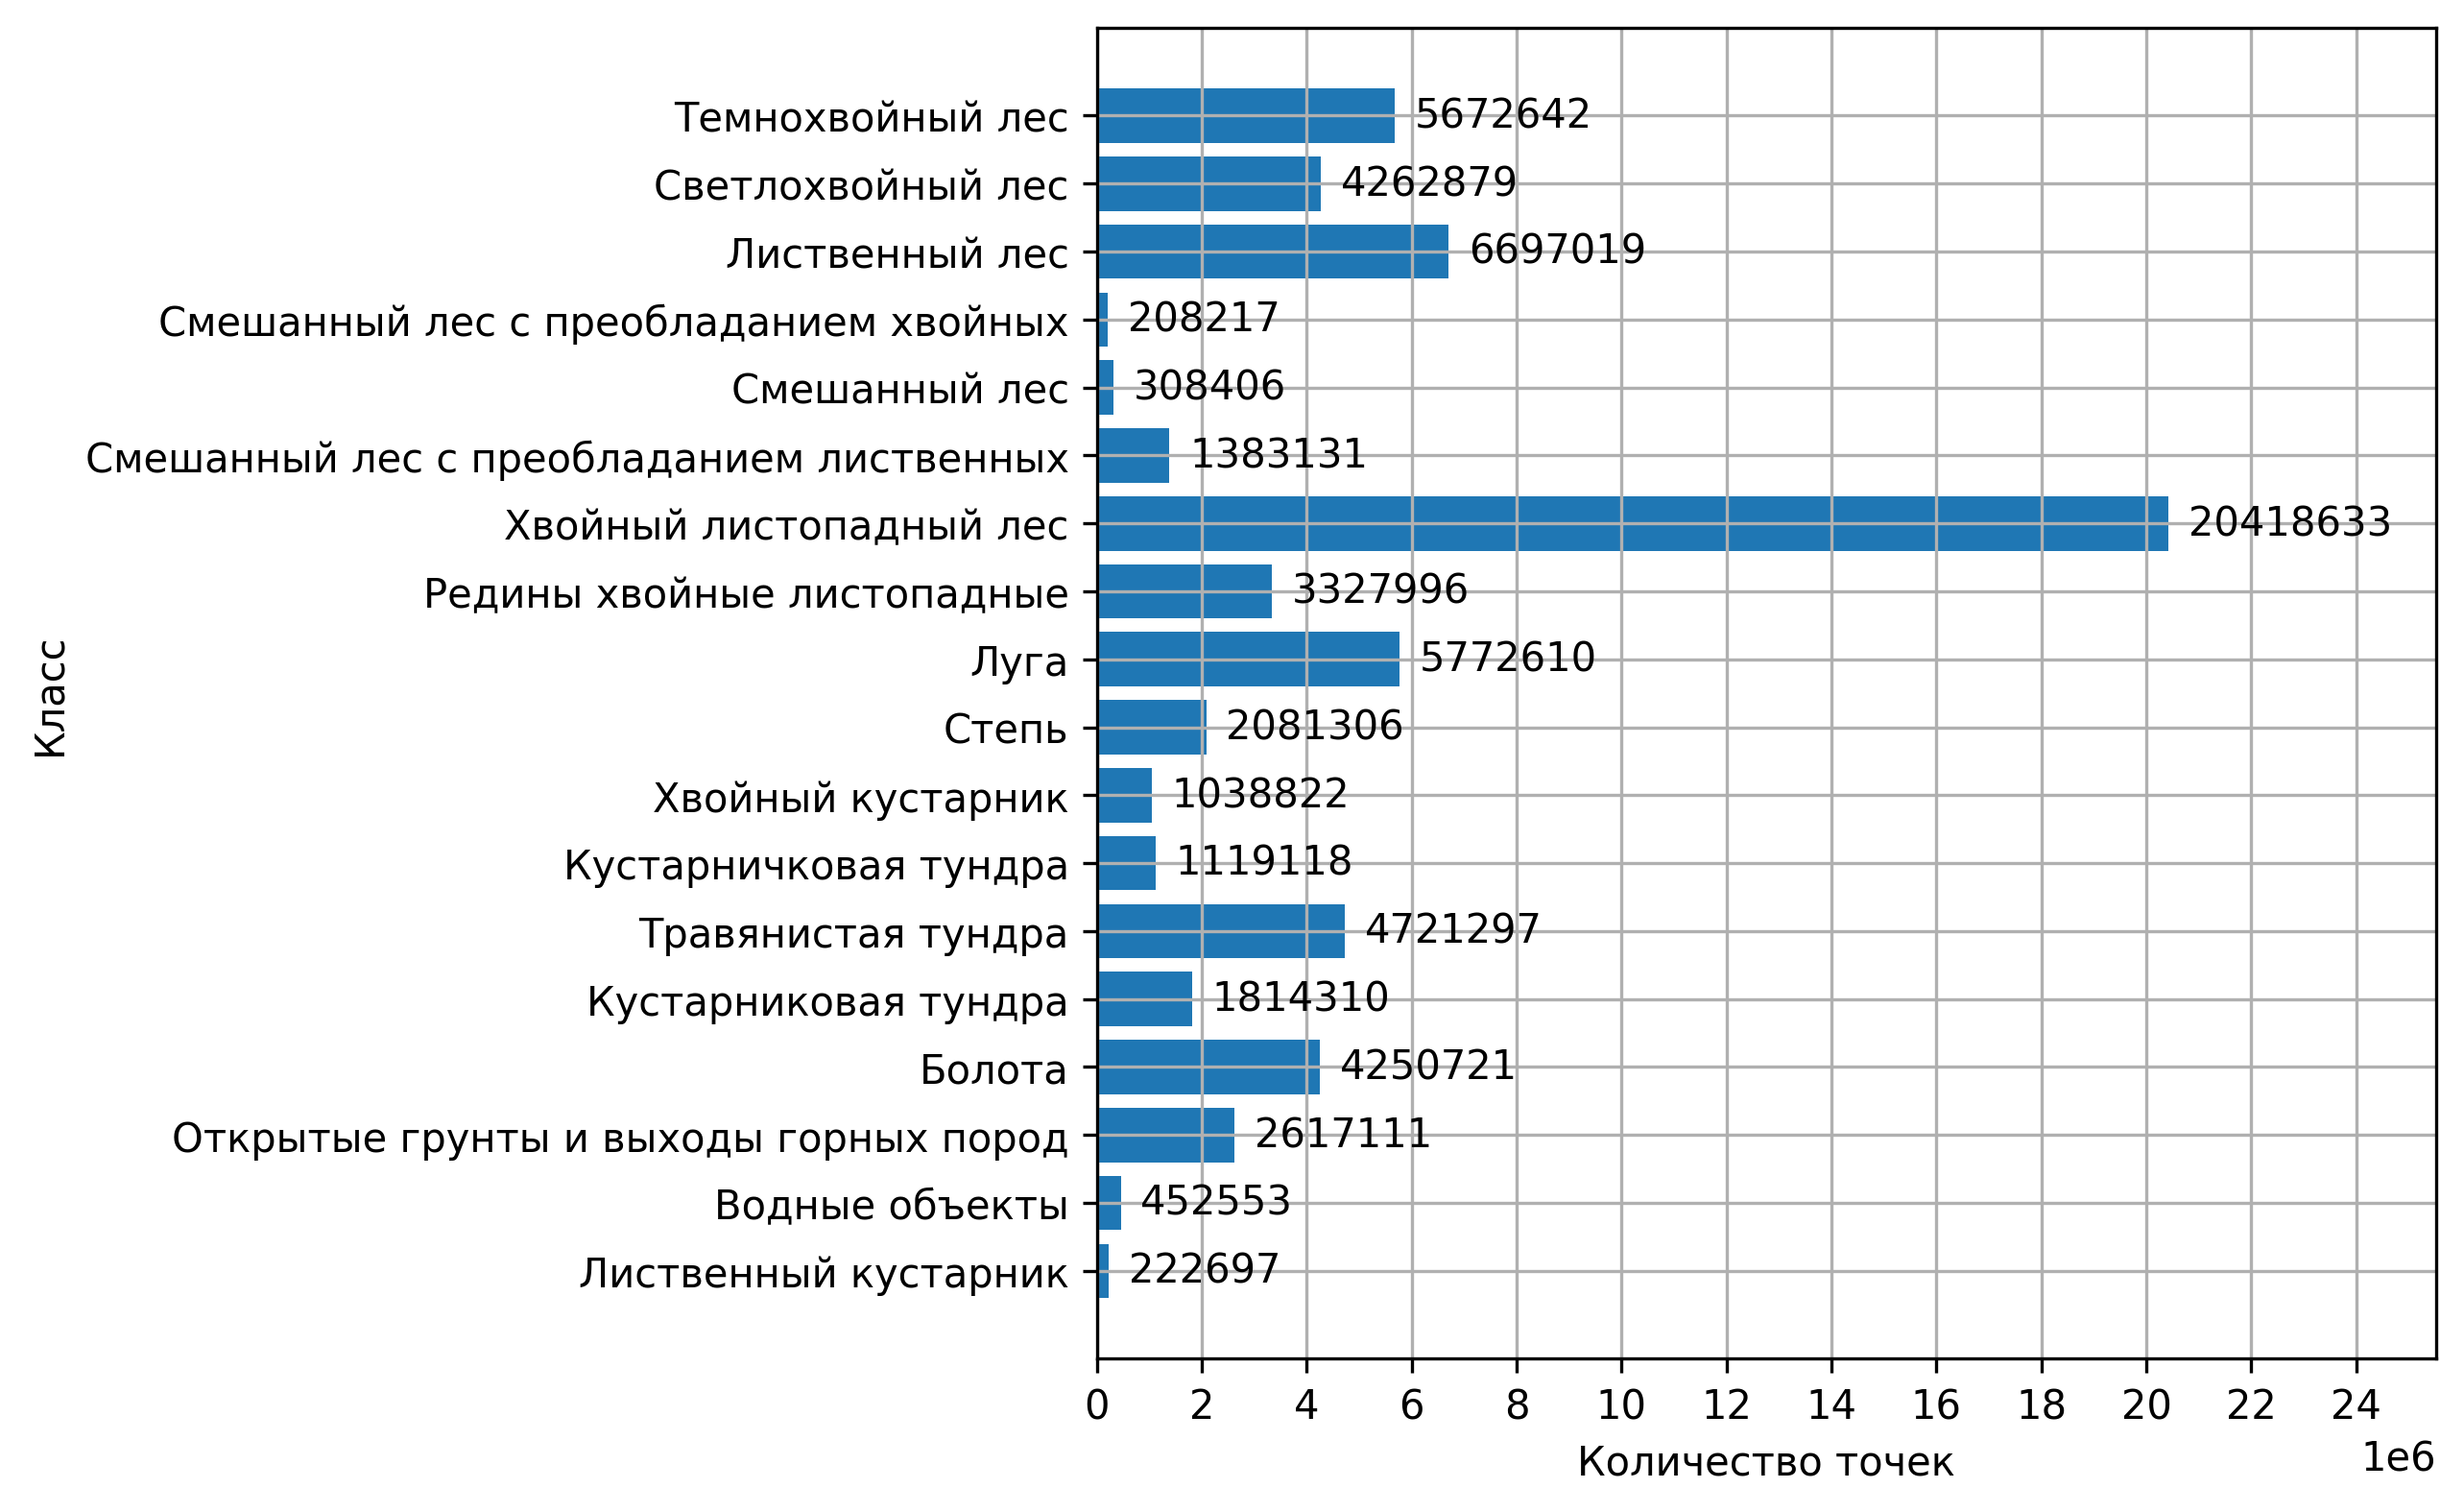

In [14]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

bars = ax.barh(np.arange(n_classes), counts, align='center')
ax.set_xticks(np.arange(0, max(counts)+4e6, 2e6))
ax.set_yticks(np.arange(n_classes), labels=stats["name"])
ax.ticklabel_format(axis='x', scilimits=(6,6))
ax.invert_yaxis()
ax.set(xlabel="Количество точек", ylabel="Класс")
ax.bar_label(bars, labels=counts, padding=5)
ax.margins(x=0.25)
ax.grid()
plt.savefig(plot_path, bbox_inches="tight")
plt.show()

## 5. Классы, имеющие смысл для пространственного разрешения 10 м

Опираясь на [описания классов земного покрова](../notes/modis-classes.md), представленные в [монографии по спутниковому картографированию растительного покрова России](articles/Барталев%20-%20Спутниковое%20картографирование%20растительного%20покрова%20России.pdf) можно предположить, что для пространственного разрешения 10 м не имеет смысла выделение смешанных лесов.